## Proyecto Final - Clasificador de hongos comestibles y venenosos por medio de CNN

<p>Click para acceder el conjunto de datos <a href="https://www.kaggle.com/datasets/marcosvolpato/edible-and-poisonous-fungi">Edible and Poisonous Fungi</a>.</p>

<style>
    .imagen-ajustada {
        width: 900px;
        height: 280px;
        border-radius: 20px;
    }
</style>

<img src="hongos.jpg" alt="Una imagen" class="imagen-ajustada">

El objetivo del proyecto es clasificar imagenes en hongos comestibles o venenosos en base a redes neuronales para una mejor clasificacion, el conjunto de datos utilizado se obtuvo por medio de Kaggle.     

## Librerias Utilizadas

In [1]:
# Importamos las liberias necesarias
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
from tensorflow.keras import datasets, layers, models
from numpy.random import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing import image

# Librerias necesarias para el aumento de datos
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils import np_utils
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
%matplotlib inline

## Analisis Exploratorio

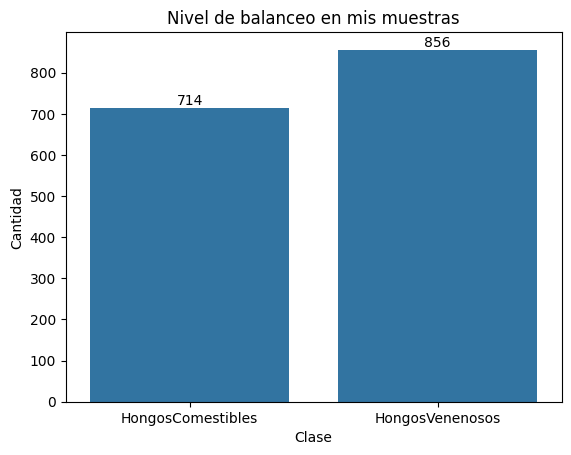

In [19]:
path = os.getcwd() + "/Dataset_Hongos"
hongos_comestibles = None
hongos_venenosos = None
for category in os.listdir(path=path):
    category_dir = os.path.join(path, category)
    if category == 'HongosComestibles':
        hongos_comestibles = len(os.listdir(category_dir))
    else: hongos_venenosos = len(os.listdir(category_dir))
data = {'Clase':['HongosComestibles', 'HongosVenenosos'], 'Cantidad': [hongos_comestibles, hongos_venenosos]}
df = pd.DataFrame(data)
sns.barplot(df, x='Clase', y="Cantidad")
for index, value in enumerate(df['Cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Nivel de balanceo en mis muestras')
plt.show()

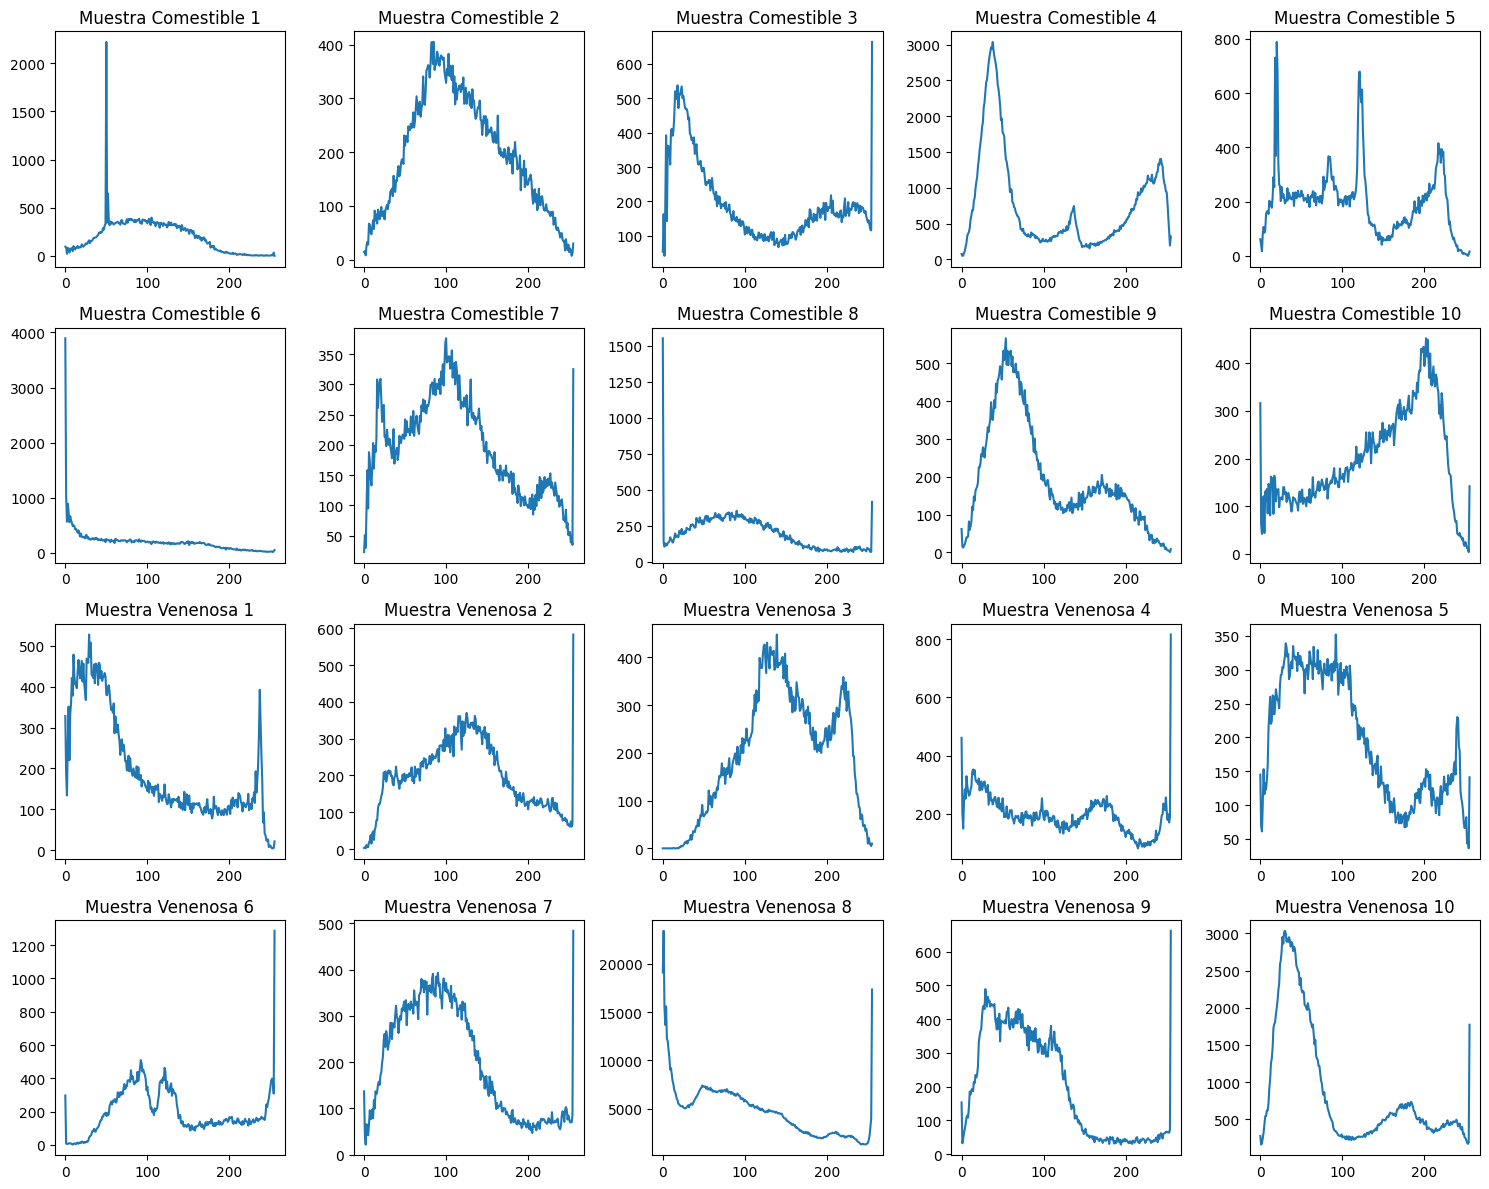

In [3]:
path = os.getcwd() + "/Dataset_Hongos"
comestibles_folder = path +'/HongosComestibles'
venenosos_folder = path +'/HongosVenenosos'
comestibles_files = os.listdir(comestibles_folder)
venenosos_files = os.listdir(venenosos_folder)
muestras_comestibles = np.random.choice(comestibles_files, 10, replace=False)
muestras_venenosas = np.random.choice(venenosos_files, 10, replace=False)
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
def plot_histogram(ax, image, title):
    RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([RGB_image], [0], None, [256], [0, 256])
    ax.plot(hist)
    ax.set_title(title)
for i, muestra_comestible in enumerate(muestras_comestibles):
    row = i // 5
    col = i % 5
    image_path = os.path.join(comestibles_folder, muestra_comestible)
    image = cv2.imread(image_path)
    plot_histogram(ax[row, col], image, f'Muestra Comestible {i + 1}')
for i, muestra_venenosa in enumerate(muestras_venenosas):
    row = (i + len(muestras_comestibles)) // 5
    col = (i + len(muestras_comestibles)) % 5
    image_path = os.path.join(venenosos_folder, muestra_venenosa)
    image = cv2.imread(image_path)
    plot_histogram(ax[row, col], image, f'Muestra Venenosa {i + 1}')
plt.tight_layout()
plt.show()

Se cargan las im&aacute;genes que seran utilizadas como datos de entrenamiento, los cuales son un 80%.

Se cargan las im&aacute;genes que seran utilizadas como datos de prueba, los cuales son un 20%.

In [4]:
# Definimos la ruta a la carpeta que contiene las imágenes que se usaran para prueba
data_test = os.getcwd() + "/Dataset_Hongos"

max_muestras = 700
# Cargamos las imágenes que se usaran para prueba 
images = []
labels = []
for category in os.listdir(data_test):
  category_dir = os.path.join(data_test, category)
  for image_file, i in zip(os.listdir(category_dir), range(max_muestras)):
    image_test = cv2.imread(os.path.join(category_dir, image_file))
    image_test = cv2.resize(image_test, (256, 256))  # Redimensionamos las imágenes a 256x256
    #cv2.imshow("check", image_test)
    #cv2.waitKey(0)
    images.append(image_test)
    labels.append(category)
cv2.destroyAllWindows()
# Convertimos las imágenes a un formato compatible con TensorFlow
images = np.array(images)
images = images.astype(np.float32)

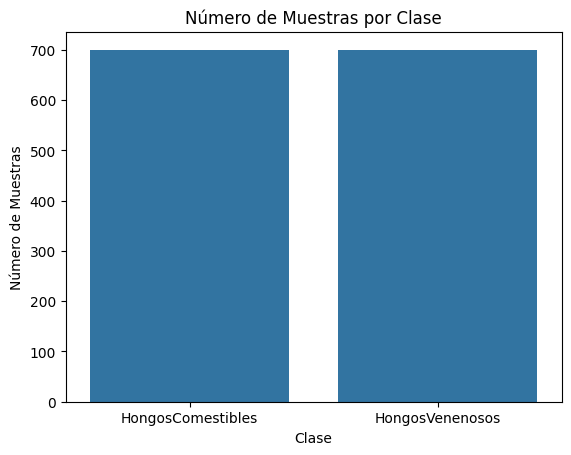

In [5]:
# Contamos la cantidad de muestras por clase
counter = dict(zip(*np.unique(labels, return_counts=True)))

# Creamos la gráfica de barras
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.title('Número de Muestras por Clase')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.show()

In [6]:

images_train, images_test, labels_train, labels_test = train_test_split(images, labels, test_size=0.2, random_state=42)
# Normalizamos los valores de los pixeles entre 0 y 1.
images_train, images_test = images_train / 255.0, images_test / 255.0

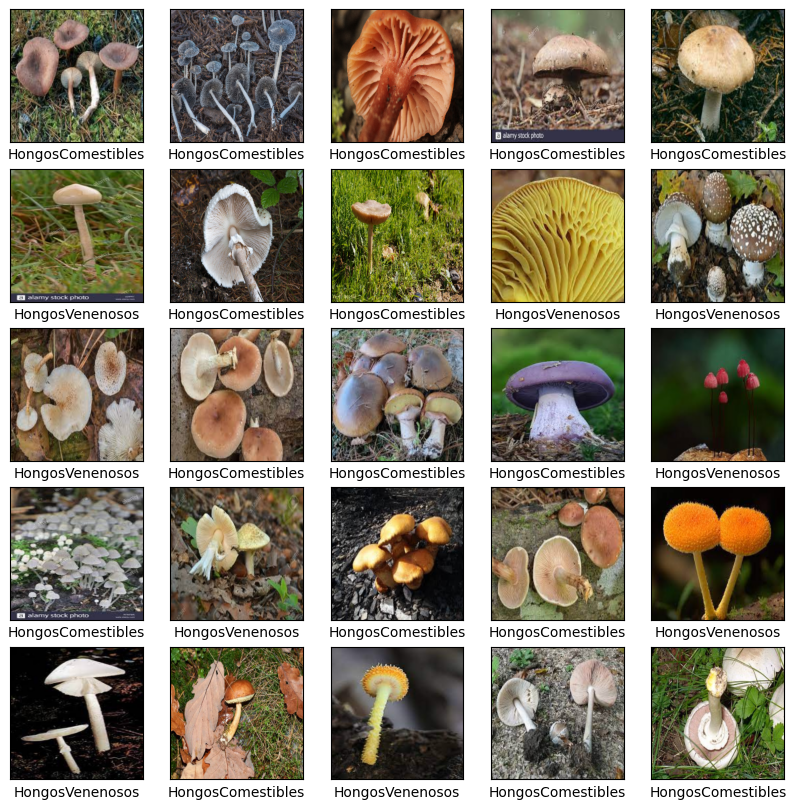

In [7]:
# Creamos una variable para que sea aleatoria entre los valores de las imágenes para poder representar 25 de ellas al azar
indexs = np.random.randint(0, len(images_train), 25)

class_names = ['HongosComestibles', 'HongosVenenosos']

plt.figure(figsize=(10,10))
for i, j in enumerate(indexs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Convertir de BGR a RGB para visualización
    image_rgb = cv2.cvtColor(images_train[j], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.xlabel((labels_train[j]))  # Se muestra el índice correspondiente a la etiqueta
plt.show()

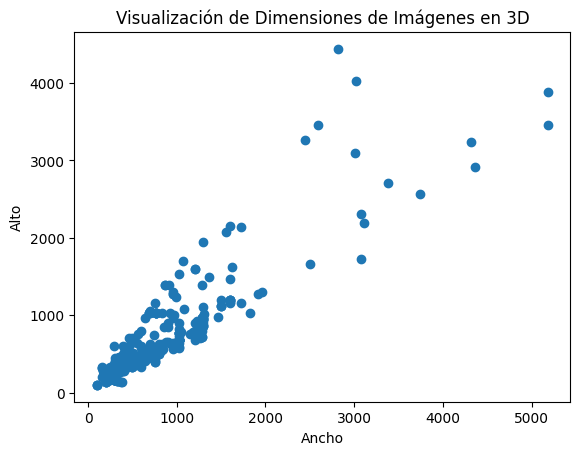

In [2]:
data_test = os.getcwd() + "/Dataset_Hongos"
dimensions = []
for folder_path in os.listdir(data_test):
    ruta = os.path.join(data_test, folder_path)
    for file in os.listdir(ruta):
        img = cv2.imread(os.path.join(ruta, file))
        if img is not None:
            height, width, _ = img.shape
            dimensions.append((width, height))
# Convierte las dimensiones a un formato numpy para facilitar la visualización
dimensions = np.array(dimensions)

# Asegúrate de que dimensions sea bidimensional
dimensions = dimensions.reshape(-1, 2)

# Visualiza las dimensiones en 3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dimensions[:, 0], dimensions[:, 1])
ax.set_title('Visualización de Dimensiones de Imágenes en 3D')
ax.set_xlabel('Ancho')
ax.set_ylabel('Alto')
plt.show()

## Tratamiento del dataset

In [9]:
# Se utiliza el label encoder para pasar las imagenes a valores de etiqueta.

encoder = LabelEncoder()

#Inicializar el objeto encoder
labels_tra = encoder.fit_transform(labels_train)

#Mostrar las herramientras numericas correspondientes
print(labels_tra)

[1 0 0 ... 1 1 1]


Se transforman las etiquetas de tipo String en valores numeros de labels_train

Ajustamos y transformamos las etiquetas en numeros para tener un mejor manejo de estos.

In [10]:
labels_tes = encoder.fit_transform(labels_test)

#Mostrar las etiquetas numericas correspondientes
print(labels_tes)

[0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0
 1 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1
 0 0 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 1 1 0 1 0
 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1
 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0
 1 1 0 1 0 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1
 0 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0]


Antes de comenzar con el diseño del modelo hay que verificar que las dimensiones de la matriz esten bien, asi como sus etiquetas.

In [11]:
print(images_train.shape)
print(labels_tra.shape)
print(images_test.shape)
print(labels_tes.shape)

(1120, 256, 256, 3)
(1120,)
(280, 256, 256, 3)
(280,)


## CNN

In [12]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
Total params: 111680 (436.25 KB)
Trainable params: 11168

Agregar capas densas en la capa superior

In [14]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [17]:
history = model.fit(images_train, labels_tra, epochs=10, 
                    validation_data=(images_test, labels_tes))

Epoch 1/10


C:\Users\ages0\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 [==============================] - 94s 3s/step - loss: 0.8622 - accuracy: 0.5134 - val_loss: 0.6904 - val_accuracy: 0.5500
Epoch 2/10
35/35 [==============================] - 83s 2s/step - loss: 0.6799 - accuracy: 0.6187 - val_loss: 0.6716 - val_accuracy: 0.6036
Epoch 3/10
35/35 [==============================] - 82s 2s/step - loss: 0.6822 - accuracy: 0.5580 - val_loss: 0.6596 - val_accuracy: 0.6250
Epoch 4/10
35/35 [==============================] - 84s 2s/step - loss: 0.6523 - accuracy: 0.6339 - val_loss: 0.6480 - val_accuracy: 0.6179
Epoch 5/10
35/35 [==============================] - 83s 2s/step - loss: 0.6250 - accuracy: 0.6589 - val_loss: 0.6540 - val_accuracy: 0.6429
Epoch 6/10
35/35 [==============================] - 83s 2s/step - loss: 0.5949 - accuracy: 0.6848 - val_loss: 0.6721 - val_accuracy: 0.6036
Epoch 7/10
35/35 [==============================] - 84s 2s/step - loss: 0.5127 - accuracy: 0.7589 - val_loss: 0.7265 - val_accuracy: 0.6036
Epoch 8/10
35/35 [=============

Evaluamos el modelo

9/9 - 6s - loss: 1.6679 - accuracy: 0.5893 - 6s/epoch - 648ms/step


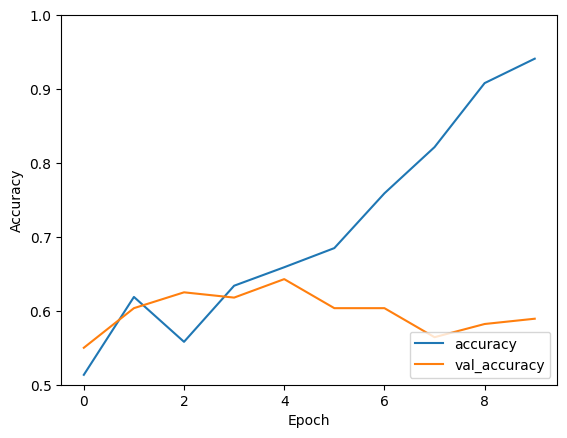

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images_test,  labels_tes, verbose=2)

In [19]:
print(test_acc)

0.5892857313156128


## Modelo 2

En base al resultado obtenido con el modelo de CNN, se intentara mejorarlo con un aumento de datos.

In [27]:
DG_folder = 'DG_data'
images_increased = 5

data_path = data_test  # Reemplaza con la ruta a tus datos
data_dir_list = os.listdir(data_path)

width_shape, height_shape = 224, 224

num_original_images = 0
num_augmented_images = 0

for folder in data_dir_list:
    ruta = os.path.join(data_path, folder)
    path_category = os.path.join(DG_folder, folder)
    
    # Recopila la lista de archivos en la carpeta actual
    files = os.listdir(ruta)
    num_files = len(files)
    num_original_category = min(int(0.7 * num_files), num_files)  # Determina el número de imágenes originales para esta categoría

    for i in range(num_original_category):
        file = files[i]
        # Carga la imagen con OpenCV
        img = cv2.imread(os.path.join(ruta, file))
        img = cv2.resize(img, (width_shape, height_shape), interpolation=cv2.INTER_AREA)
        img = (img - img.min()) / (img.max() - img.min())  # Normaliza los valores de píxeles a valores entre 0 y 1
        # Guarda la imagen original
        cv2.imwrite(os.path.join(path_category, f"{i}_0.jpg"), (img * 255).astype(np.uint8))
        num_original_images += 1

        # Aplica aumentos de datos utilizando OpenCV
        for t in range(1, images_increased + 1):
            # Realiza una rotación aleatoria
            angle = np.random.uniform(-20, 20)
            M = cv2.getRotationMatrix2D((width_shape / 2, height_shape / 2), angle, 1.0)
            rotated_img = cv2.warpAffine(img, M, (width_shape, height_shape))
            # Realiza un cambio de escala aleatorio (zoom)
            scale_factor = np.random.uniform(0.8, 1.2)
            scaled_img = cv2.resize(rotated_img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
            # Realiza un cambio de posición aleatorio
            dx = np.random.randint(-10, 10)
            dy = np.random.randint(-10, 10)
            translated_img = np.roll(scaled_img, (dx, dy), axis=(0, 1))
            # Voltea horizontalmente aleatoriamente
            if np.random.choice([True, False]):
                flipped_img = cv2.flip(translated_img, 1)
            else:
                flipped_img = translated_img
            # Guarda la imagen aumentada
            cv2.imwrite(os.path.join(path_category, f"{i}_{t}.jpg"), (flipped_img * 255).astype(np.uint8))
            num_augmented_images += 1

print("Total original images:", num_original_images)
print("Total augmented images:", num_augmented_images)


Total original images: 1098
Total augmented images: 5490


In [ ]:
width_shape = 224
height_shape = 224
num_classes = 10
epochs = 10
batch_size = 32 

## Comparaciones

## Conclusiones